In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Algorithms.ddpg import config

# 0. Plot setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# Seed Setting

In [3]:
import torch as th
import torch.nn as nn
import random

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    # os.environ["PYTHONHASHSEED"] = str(seed) # os
    th.manual_seed(seed)
    # th.cuda.manual_seed(seed)
    # th.backends.cudnn.deterministic = True
    # th.backends.cudnn.benchmark = False

# 1. Recall results

## 1. GBM

In [27]:
def geometric_brownian_motion(n_paths, maturity=30, dt=1 / 365, drift=0.0, volatility=0.2, device=None) -> th.Tensor:

    # normal_rand = th.randn(size=(maturity, n_paths))
    normal_rand = th.from_numpy(np.random.randn(maturity, n_paths))
    normal_rand[0, :] = 0.0

    noise_term = volatility * (dt ** 0.5) * normal_rand.cumsum(dim=0)   # normal_variable에 대한 cumsum이므로 variance가 dt만큼 가중돼 누적되어 나중에는 t만큼 벌어진다.
    t = th.linspace(0, maturity*dt, maturity)[:, None]    # set same device with noise_term
    return th.exp((drift - 0.5*volatility**2)*t + noise_term)


def geometric_brownian_motion2(n_paths: int, n_periods: int = 30,
                               drift: float = 0.0, volatility: float = 0.2,
                               init_price: float = 1.0, dt: float = 1/365) -> np.ndarray:

    z = np.random.standard_normal((n_periods, n_paths))
    z[0, :] = 0.0

    noise_term = volatility * np.sqrt(dt) * z.cumsum(axis=0)

    t = np.linspace(0, n_periods*dt, n_periods).reshape(-1, 1)
    # t = np.arange(0, n_periods*dt, dt).reshape(-1, 1)
    return init_price*np.exp((drift - 0.5 * volatility ** 2) * t + noise_term)

In [32]:
set_seed()
gbm1 = geometric_brownian_motion(1)
set_seed()
gbm2 = th.tensor(geometric_brownian_motion2(1))

th.all(gbm1 - gbm2 < 1e-7)

tensor(True)

## 1.2 Delta

In [33]:
# from Utils.prices import european_call_delta
from scipy.stats.distributions import norm

def european_option_delta(moneyness, expiry, volatility):
    s, t, v = map(th.as_tensor, (moneyness, expiry, volatility))
    normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))
    delta = normal.cdf((s.log()+(v**2/2)*t) / (v*th.sqrt(t)))
    return delta

def european_option_delta2(moneyness: np.ndarray,
                        expiry: np.ndarray,
                        volatility: float,
                        risk_free_interest: float = 0.0,
                        strike: float = 1.0, dividend: float = 0.0) -> np.ndarray:

    normal = norm(loc=0.0, scale=1.0)
    d1 = european_option_d1(moneyness, expiry, volatility, risk_free_interest)
    return normal.cdf(d1) * np.exp(-dividend * expiry)

def european_option_d1(moneyness: np.ndarray,
                       expiry: np.ndarray,
                       volatility: float,
                       risk_free_interest: float=0.0) -> np.ndarray:

    a = np.log(moneyness) + (risk_free_interest + 0.5 * volatility ** 2) * expiry
    b = volatility * np.sqrt(expiry)

    return a / b

In [34]:
moneyness = th.distributions.Normal(1., 0.2).sample((10, ))
expiry = th.full_like(moneyness, 15/365)
vol = th.full_like(moneyness, 0.2)


delta1 = european_option_delta(moneyness, expiry, vol).numpy()
delta2 = european_option_delta2(moneyness.numpy(), expiry.numpy(), vol.numpy())
# delta2 = european_option_d1(moneyness.numpy(), expiry.numpy(), vol.numpy())

np.all(delta1 - delta2 < 1e-7)

True

## 1.3 Payoff

In [35]:
def european_option_payoff(prices: th.Tensor, strike=1.0) -> th.Tensor:
    return th.nn.functional.relu(prices - strike)

def european_option_payoff2(prices: np.ndarray, strike: float = 1.0) -> np.ndarray:
    return np.clip(prices - strike, 0.0, np.inf)

In [36]:
tmp = th.randn(100)
np.all(european_option_payoff(tmp).numpy()==european_option_payoff2(tmp.numpy()))

True

## 1.4 P&L

In [108]:
# def compute_pnl(n_assets=1000):
#
#     prices = geometric_brownian_motion(n_assets)  # prices over all time, shape (n_steps, n_paths)
#
#     hedge = th.zeros_like(prices[0])        # positions, shape (n_paths, )
#     pnl = 0
#
#     maturity = 30
#     dt = 1/365
#     vol_arg = 0.2
#     transaction_cost = 1e-3
#
#     for i in range(prices.shape[0] - 1):
#         # env's observations
#         moneyness = prices[i]  # obs_1, shape (n_paths, 1)
#         time_expiry = th.full_like(moneyness, (maturity - i)*dt)
#         volatility = th.full_like(moneyness, vol_arg)
#
#         prev_hedge = hedge
#         hedge = european_option_delta(moneyness, time_expiry, volatility)
#
#         # gain from price movement + loss from hedge movement
#         pnl += hedge * (prices[i+1]-prices[i]) - transaction_cost * th.abs(hedge - prev_hedge) * prices[i]
#
#     # buyer's option execution (so, it is loss for seller=(us))
#
#     pnl -= european_option_payoff(prices[-1])
#
#     return pnl

from Utils.prices import geometric_brownian_motion, european_call_delta, european_option_payoff
def compute_pnl2(n_assets=1000):

    prices = geometric_brownian_motion(n_assets, 30, 0.0, 0.2, 1.0, 1/365)  # prices over all time, shape (n_steps, n_paths)
    hedge = np.zeros_like(prices[0])        # positions, shape (n_paths, )
    pnl = 0

    maturity = 30
    dt = 1/365
    vol_arg = 0.2
    # transaction_cost = 2e-2
    transaction_cost = 1e-3

    for i in range(prices.shape[0] - 1):
        # env's observations
        z = i
        moneyness = prices[z]  # obs_1, shape (n_paths, 1)
        time_expiry = np.full_like(moneyness, (maturity - z)*dt)
        volatility = np.full_like(moneyness, vol_arg)

        prev_hedge = hedge
        hedge = european_call_delta(moneyness, time_expiry, volatility)

        # gain from price movement + loss from hedge movement
        gain = hedge * (prices[i+1]-prices[i]) - transaction_cost * np.abs(hedge - prev_hedge) * prices[i]
        print(np.round(hedge[:5], 4), end=" ")
        print(np.round(gain[:5], 4))
        pnl += gain

    # buyer's option execution (so, it is loss for seller=(us))

    pnl -= european_option_payoff(prices[-1])
    print(np.round(european_option_payoff(prices[-1])[:5], 4))

    return pnl, prices

In [109]:
# set_seed()
# pnl = compute_pnl().numpy()

In [110]:
set_seed()
pnl2, prices = compute_pnl2()

[0.5114 0.5114 0.5114 0.5114 0.5114] [ 0.007   0.0044 -0.0002 -0.004   0.0032]
[0.613  0.5788 0.5153 0.463  0.5623] [-0.0045 -0.001  -0.0043 -0.0016 -0.0112]
[0.5646 0.5687 0.4551 0.4385 0.4207] [-0.0113 -0.0052 -0.002   0.0086  0.0023]
[0.4193 0.5035 0.4221 0.5807 0.4607] [-0.0039 -0.0003  0.      0.0027 -0.0066]
[0.3524 0.5003 0.4212 0.6172 0.3554] [-0.0016 -0.0024 -0.0078 -0.0022  0.0026]
[0.318  0.4633 0.2864 0.5933 0.4076] [-0.0036 -0.0031 -0.0029 -0.0035 -0.001 ]
[0.2381 0.411  0.2207 0.5505 0.3881] [ 0.0018 -0.0076  0.0015 -0.0014  0.0028]
[0.2856 0.2734 0.2612 0.5314 0.4423] [-0.0002 -0.0015 -0.0005  0.004   0.0058]
[0.2782 0.234  0.2442 0.5912 0.5485] [ 0.0021  0.0025  0.0012 -0.0121 -0.001 ]
[0.3309 0.3047 0.2733 0.4246 0.5353] [-0.0024 -0.001  -0.0017  0.0003  0.0067]
[0.2735 0.2762 0.2256 0.4315 0.6391] [-0.0033  0.0012  0.0025  0.0034  0.0073]
[0.1866 0.3041 0.3013 0.4976 0.7296] [ 0.0021 -0.0058 -0.0011 -0.0003 -0.    ]
[0.2609 0.1655 0.2694 0.4926 0.7356] [-0.0001  0.000

In [66]:
delta_best = np.load('delta_best.npy')

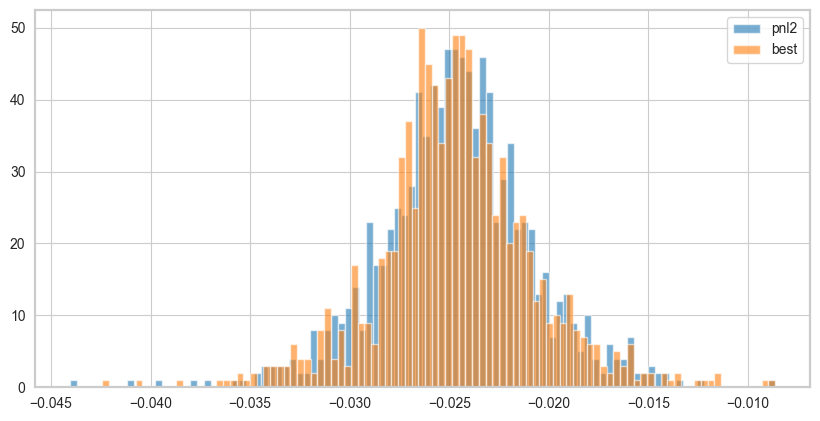

-0.024656186791497874


In [90]:
plt.hist(pnl2, bins=100, alpha=0.6, label='pnl2')
plt.hist(delta_best, bins=100, alpha=0.6, label='best')
# plt.hist(delta_pnl, bins=100, alpha=0.6, label='rl')
plt.legend()
plt.show()

# print(np.mean(delta_pnl))
print(np.mean(pnl2))

# 2. For Env

In [120]:
from Env.env import BSMarket
env = BSMarket(1000, cost=1e-3, payoff_coeff=0.0)

env 'BSMarket was created!


In [80]:
env.underlying_prices.shape

(30, 1000)

In [121]:
def delta_eval2():
    # env.now = 0
    # env.hold = np.zeros_like(env.hold)
    # obs = env.get_obs()
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    # i = 0
    while not done:
        moneyness, expiry, volatility = [obs[..., j] for j in range(3)]
        action = european_call_delta(moneyness, expiry, volatility)
        assert np.all(action - env.delta[env.now] < 1e-7)
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']
        print(np.round(action[:5], 4), end=" ")
        print(np.round(info['raw_reward'][:5], 4))
        # i += 1

    return total_raw_reward

In [122]:
delta_pnl = delta_eval2()

[0.5114 0.5114 0.5114 0.5114 0.5114] [-0.0052  0.0018 -0.0016  0.0037 -0.0075]
[0.4461 0.543  0.4965 0.5686 0.4151] [ 0.0001 -0.0034  0.0015  0.0067 -0.0014]
[0.4473 0.4989 0.518  0.6504 0.3911] [ 0.0059 -0.      0.0113  0.0058  0.0023]
[0.5421 0.4987 0.6707 0.7106 0.4313] [ 0.001  -0.0015  0.0032 -0.0123  0.0049]
[0.5571 0.475  0.7052 0.5981 0.5152] [-0.003  -0.0047 -0.0009  0.0021 -0.0013]
[0.517  0.3988 0.7009 0.6261 0.4966] [ 0.0027 -0.0014  0.01   -0.008   0.0031]
[0.5582 0.3703 0.7901 0.5324 0.5453] [ 0.0103 -0.0005 -0.0007 -0.0012  0.0031]
[0.6953 0.3586 0.7903 0.5163 0.5908] [-0.0024 -0.0022  0.0127  0.0063  0.0033]
[0.6757 0.3088 0.8722 0.613  0.6355] [ 0.0098 -0.0018 -0.0004 -0.0061 -0.0004]
[0.7764 0.264  0.8759 0.5354 0.634 ] [ 0.0086 -0.0031  0.0055 -0.0036 -0.0022]
[0.8431 0.1821 0.9048 0.4802 0.6085] [ 0.0105 -0.0006  0.0127  0.0054  0.003 ]
[0.9022 0.1602 0.9484 0.5771 0.651 ] [-0.0075 -0.0007 -0.0194  0.0073  0.004 ]
[0.8755 0.1315 0.8929 0.6855 0.7036] [-0.0064 -0.001

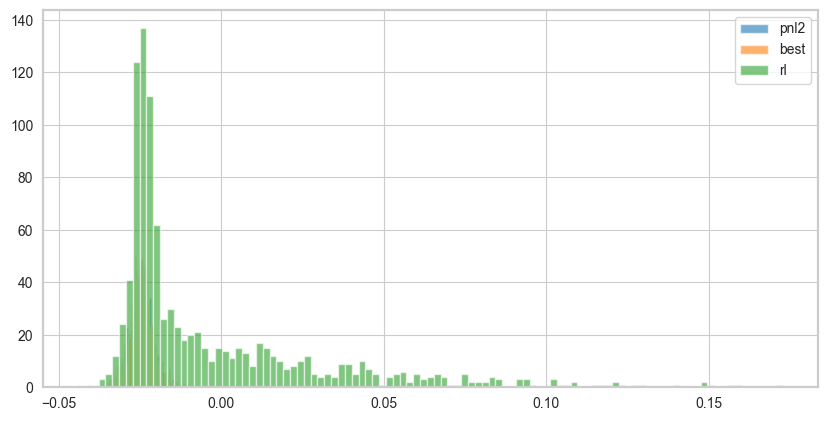

-0.024656186791497874
-0.0029054321398454394


In [123]:
plt.hist(pnl2, bins=100, alpha=0.6, label='pnl2')
plt.hist(delta_best, bins=100, alpha=0.6, label='best')
plt.hist(delta_pnl, bins=100, alpha=0.6, label='rl')
plt.legend()
plt.show()

print(np.mean(pnl2))
print(np.mean(delta_pnl))